In [1]:
import skyfield.api as sf 
import os 
import pandas as pd 
import json 
import numpy as np
import matplotlib.pyplot as plt


In [2]:
data = {'Satellites': [{'Name':'NOAA 18 [B]','Frequency_kHz':137000},
                      {'Name':'NOAA 15 [B]','Frequency_kHz':137000}],
        'Altitude_threshold_degrees': 20,
        'Location': {'Latitude': 55.7933,'Longitude': -4.8672},
        'TLE_dir':'.'}
with open('config.json', 'w') as f:
    json.dump(data, f, ensure_ascii=True)

In [3]:
def read_TLE(TLE_dir):
    if os.path.isdir(TLE_dir): 
        satellites = {} 
        files = os.listdir(TLE_dir) 
        for file in files: 
            if file.endswith(".txt"): 
                satellites.update(sf.load.tle(os.path.join(TLE_dir,file))) 
    return satellites 


In [4]:
def read_config(config_json): 
    if os.path.isfile(config_json): 
        with open(config_json, 'r') as f: 
            config_data = json.load(f) 
    return(config_data) 

In [5]:
def doppler_shift (f,delta_v):
    pass

In [23]:
c = 299792458

In [94]:
def next_pass (config_json):
    TLEs = read_TLE(TLE_dir) 
    station = sf.Topos(config_json['Location']['Latitude'], config_json['Location']['Longitude']) 
    satellites = config_json["Satellites"]
    ts = sf.load.timescale() 
    t = ts.now() 
    print('now time is {0} UTC'.format(t.utc_datetime()))
    d = ts.utc(t.utc[0], t.utc[1], t.utc[2]+1) - t
    #T = ts.tt_jd(t.tt + np.array(range(0,int(d * 8640))) * (1/8640))
    T = ts.tt_jd(t.tt + np.array(range(0,8640)) * (1/8640))
    last_duration = 0
    for satellite in satellites: 
        if satellite['Name'] in TLEs.keys(): 
            geocentric = TLEs[satellite['Name']].at(T)
            subpoint = geocentric.subpoint()
            loc_difference = TLEs[satellite['Name']] - station
            topocentric = loc_difference.at(T)
            alt, az, distance = topocentric.altaz()
            
            # separate periods
            j = (alt.degrees >= 0) * 1
            k = j[1:] - j[0:-1]
            s = np.argwhere(k == 1).reshape(-1)
            e = np.argwhere(k == -1).reshape(-1)
            for si in s:
                h = e[e>si].reshape(-1).min()
                if h > 0:
                    if (alt.degrees[si:h] >= config_json["Altitude_threshold_degrees"]).any():
                        cur_duration = T[h] - T[si]
                        if cur_duration > last_duration:
                            last_duration =  cur_duration
                            cur_df = pd.DataFrame(data=None)
                            delta_t = np.diff(T[si-1:h]) * 86400 # seconds
                            cur_df['Azimuth_degrees'] = az.degrees[si:h]
                            cur_df['Distance_km'] = distance.km[si:h]
                            cur_df['Altitude_degrees'] = alt.degrees[si:h]
                            cur_df['Latitude'] = subpoint.latitude.degrees[si:h]
                            cur_df['Longitude'] = subpoint.longitude.degrees[si:h]
                            cur_df['UTC_time'] = T.utc_datetime()[si:h]
                            delta_distance_meter = np.diff(distance.km[si-1:h]) * 1e3
                            range_rate = delta_distance_meter / delta_t
                            cur_df['doppler_shift'] =  (1-(range_rate / c)) 
                            cur_df['Satellite'] = satellite['Name']
                            break
    return cur_df
            #cur_df['Elevation'] = subpoint.elevation

In [113]:
def record_pass(pass_df):
    pass_duration = pass_df.iloc[-1]['UTC_time'] - pass_df.iloc[0]['UTC_time']
    print('pass will last {0} seconds'.format(pass_duration.seconds))
    #sox -b 32 -e unsigned-integer -r 96k -c 2 -d --clobber --buffer $((96000*2*10)) /tmp/soxrecording.wav trim 0 10
    #s = ['sox', '-b 16', '-r 192k',path/to/silence.wav',]
    #subprocess.call(s)
    for row in pass_df.iterrows():
        pass
        #print(row)

now time is 2019-01-07 07:34:54.636000+00:00 UTC
next pass is of NOAA 18 [B] starting at UTC 2019-01-07 08:39:34.636000+00:00


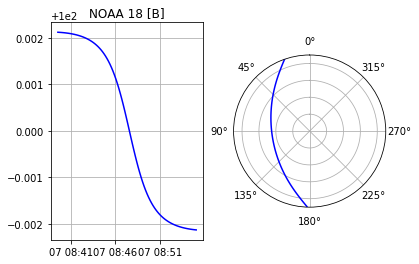

3874
pass will last 930 seconds


In [115]:
day_pd = pd.DataFrame(data=None)
TLE_dir = '/usr/local/etc/TLE'                      # Define the main function 
config_json = read_config('config.json') 
if 'TLE_dir' in config_json.keys():
    if os.path.isdir(config_json['TLE_dir']):
        TLE_dir = config_json['TLE_dir']
# check that SOX is available

if config_json: 
    pass_df = next_pass(config_json)
    print('next pass is of {0} starting at UTC {1}'.format(pass_df.iloc[0]['Satellite'],pass_df.iloc[0]['UTC_time']))
    plt.figure()
    ax = plt.subplot(122, projection='polar')
    ax.plot(pass_df['Azimuth_degrees']*np.pi/180, 90-pass_df['Altitude_degrees'],'b-')
    ax.set_ylim(bottom = 0,top = 90)
    ax.set_theta_zero_location("N")
    ax.set_yticklabels([])
    ax = plt.subplot(121 )
    ax.plot_date(pass_df['UTC_time'], 100* pass_df['doppler_shift'] ,'b-')
    ax.grid()
    plt.title(pass_df.iloc[0]['Satellite'])
    plt.show()
    ts = sf.load.timescale() 
    # time until next pass
    wait_time = pass_df.iloc[0]['UTC_time']  - ts.now().utc_datetime()
    print(wait_time.seconds)
    # wait until next pass
    # record pass
    record_pass(pass_df)
#s = ['sox', '-m', 'path/to/silence.wav',]
#subprocess.call(s)
            

In [110]:
duration = pass_df.iloc[-1]['UTC_time'] - pass_df.iloc[0]['UTC_time']

In [112]:
duration.seconds/60

15.5